In [1]:
import plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import json
from torch.utils.data import DataLoader , TensorDataset
df = pd.read_csv('telemetry_watch.csv')

from sklearn import preprocessing


In [2]:

df = pd.read_csv('telemetry_watch.csv')


In [3]:
''' Read the json files and add the labels to our dataframe

'''


def read_json(filename):
  with open('grmsx_labels.json') as user_file:
    file_contents = user_file.read()
    

  parsed_json = json.loads(file_contents)
  parsed_json = parsed_json[0]

  parsed_json= parsed_json['annotations'][0]['result']
  parsed_json

  labels = []

  labels_gx = []
  is_inst = []

  for i in range(436):
      labels_gx.append('label')
      is_inst.append('No')

  for elem in parsed_json:
      start_idx = elem['value']['start']
      end_idx = elem['value']['end']
      label = elem['value']['timeserieslabels'][0]
      

      
      for i in range(start_idx, end_idx + 1 ):
        
        
        if label == 'Instant Change':
          is_inst[i] = 'Yes'
          labels_gx[i] = 'None'

        else:
          is_inst[i] = 'No'
          labels_gx[i] = label
  return labels_gx, is_inst


In [4]:

filename = 'grmsx_labels.json'
labels_gx, is_instgx = read_json(filename)

labels = []
is_inst = [] 

labels.extend(labels_gx)
is_inst.extend(is_instgx)


filename = 'grmsy_labels.json'
labels_gy, is_instgy = read_json(filename)

labels.extend(labels_gy)
is_inst.extend(is_instgy)

filename = 'grmsz_labels.json'
labels_gz, is_instgz = read_json(filename)

labels.extend(labels_gz)
is_inst.extend(is_instgz)

filename = 'vrmsx_labels.json'
labels_vx, is_instvx = read_json(filename)

labels.extend(labels_vx)
is_inst.extend(is_instvx)

filename = 'vrmsy_labels.json'
labels_vy, is_instvy = read_json(filename)

labels.extend(labels_vy)
is_inst.extend(is_instvy)

filename = 'vrmsz_labels.json'
labels_vz, is_instvz = read_json(filename)

labels.extend(labels_vz)
is_inst.extend(is_instvz)

filename = 'temp_labels.json'
labels_temp, is_inst_temp = read_json(filename)

labels.extend(labels_temp)
is_inst.extend(is_inst_temp)


In [5]:
# creating dataset and scaling values to combine 


def scale_data(scaler, data):
    data = np.array(data)
    data = data.reshape(-1,1)
    data = scaler.fit_transform(data)
    
    return data
    
data = []
scaler = MinMaxScaler()

grmsx_data = scale_data(scaler, df.GRMS_X)
data.extend(grmsx_data)

grmsy_data = scale_data(scaler, df.GRMS_Y)
data.extend(grmsy_data)

grmsz_data = scale_data(scaler, df.GRMS_Z)
data.extend(grmsz_data)

vrmsx_data = scale_data(scaler, df.VRMS_X)
data.extend(vrmsx_data)

vrmsy_data = scale_data(scaler, df.VRMS_Y)
data.extend(vrmsy_data)

vrmsz_data = scale_data(scaler, df.VRMS_Z)
data.extend(vrmsz_data)

temp_data = scale_data(scaler, df.temperature)
data.extend(temp_data)



In [6]:

new_data = []

for i in range(len(data)):
    new_data.append(data[i][0])
    
data = new_data
data
def create_dataframe(values, labels,is_inst):
  df = pd.DataFrame()
  df['Values'] = values
  df['Labels'] = labels
  df['is_instant'] = is_inst
  
  return df

values = data
labels = labels
is_inst = is_inst


In [7]:
# get rid of non label

df_merged = create_dataframe(values, labels, is_inst)
df_merged.drop(df_merged[df_merged['Labels'] == 'label'].index, inplace = True)
df_merged.drop(df_merged[df_merged['Labels'] == 'None'].index, inplace = True)




In [8]:
df_merged

,Values,Labels,is_instant
0,0.000123,Stable,No
1,0.000241,Stable,No
2,0.000186,Stable,No
3,0.000155,Stable,No
4,0.000204,Stable,No
...,...,...,...
3047,0.097291,Stable,No
3048,0.098054,Stable,No
3049,0.092331,Stable,No
3050,0.010301,Stable,No


In [9]:
fig = px.scatter(df_merged, y ='Values', color = 'Labels', labels = {"Labels":"Labels"}, title= "Data vs Labels")
fig.show()


In [10]:
# Use label encoder so that we can put these labels into our model

le = preprocessing.LabelEncoder()
le.fit(['Stable', 'Linear'])

labels =list(df_merged['Labels'])
values = list(df_merged['Values'])

labels = le.transform(labels)
labels


array([1, 1, 1, ..., 1, 1, 1])

In [11]:
# Split the dataset where label changes

data_batches = []

start_idx = 0
end_idx = 0

while end_idx < len(values):
    current_label = labels[start_idx]
    end_idx+=1
    if labels[end_idx] == current_label:
        end_idx = end_idx + 1
    else:
        end_idx -= 1
        data_batch = labels[start_idx:end_idx+1]
        data_batches.append(data_batch)
        start_idx = end_idx + 1
        
        
data_batches


[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [12]:
# sweep data using windows of length seq_length

def sliding_windows(data,seq_length):
    x = []
    y = []
    
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    
    return np.array(x), np.array(y)
data_seqx= []
data_seqy= []

for elem in data_batches:
    window_x, window_y = sliding_windows(elem, 10)
    window_x = window_x.tolist()
    window_y = window_y.tolist()
    data_seqx.extend(window_x)
    data_seqy.extend(window_y)
    print(data_seqx)
len(data_seqx)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0,

2493

In [13]:
# Create datasets 

train_dataset = TensorDataset(torch.Tensor(data_seqx), torch.Tensor(data_seqy))
test_dataset = TensorDataset(torch.Tensor(data_seqx), torch.Tensor(data_seqy))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [14]:


#class LSTMModel(nn.Module):
#    def __init__(self,num_classes, input_size, hidden_size,num_layers):
#        super(LSTMModel, self).__init__()
        
#        self.num_classes = num_classes
#        self.num_layers = num_layers
#        self.input_size = input_size
#        self.hidden_size = hidden_size
        
#        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
#                            num_layers = num_layers, batch_first = True)
        
#        self.fc = nn.Linear(hidden_size,num_classes)
        
              
#    def forward(self, x):
    
#        x = x.unsqueeze(0)
#        
#        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
#        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
#        out, _ = self.lstm(x, (h_0, c_0))
#        print(out.shape)
#        out = self.fc(out.view(-1, self.hidden_size))
#        print(out.shape)
        
#        return  out
    


In [15]:
# Construct your model

class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model 
        self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True) 
        # batch_first=True (batch_dim, seq_dim, feature_dim)

        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        
        x = x.unsqueeze(0)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[-1]) 

        return out

Epoch [1/100], Loss: 0.5274600386619568


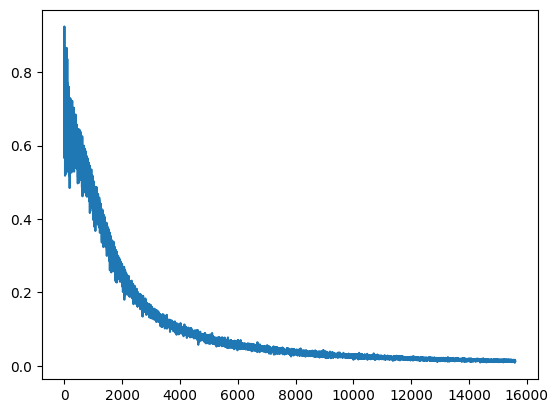

In [16]:
# Training 

num_epochs = 100
learning_rate = 0.01

input_size = 10
hidden_size = 2
num_layers = 1

num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTMModel(input_size, hidden_size, num_layers, num_classes)
loss_list = []
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)




for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        
        inputs, targets =  inputs.to(device), targets.to(device)
    
        targets = targets.long()
        outputs = lstm(inputs)
        outputs
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if epoch % 100 == 0:

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

plt.plot(loss_list)
plt.show()

train predictions: tensor([[-1.8285,  2.1781],
        [-2.4169,  2.7732],
        [-2.5726,  2.9306],
        ...,
        [ 2.2165, -2.3386],
        [ 2.2157, -2.3373],
        [ 2.2136, -2.3342]])
train predictions: tensor([[0.1384, 0.8983],
        [0.0819, 0.9412],
        [0.0709, 0.9493],
        ...,
        [0.9017, 0.0880],
        [0.9016, 0.0881],
        [0.9015, 0.0883]])
data predicitons: [1 1 1 ... 0 0 0]
Validation Accuracy100.0


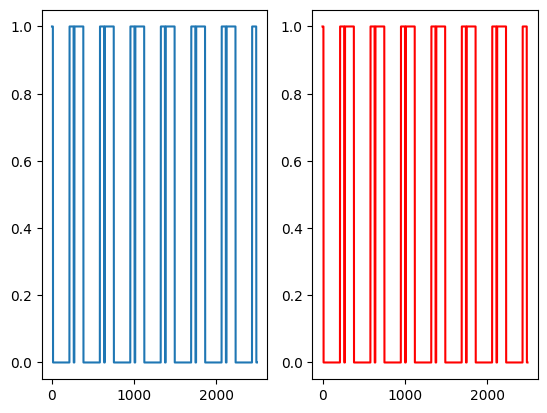

In [17]:

with torch.no_grad():
    lstm.eval()
    dataX, dataY = test_dataset.tensors
    dataX, dataY = dataX.to(device), dataY.to(device)
    train_pred = lstm(dataX)
    print("train predictions:",train_pred)
    
    train_pred = torch.sigmoid(train_pred)
    print("train predictions:",train_pred)

    data_pred = np.array(train_pred)
    data_pred = np.argmax(data_pred,axis =1)
    print('data predicitons:', data_pred)
    dataY_plot = dataY.data.cpu().numpy()
    

with torch.no_grad():
            correct = 0
            total = 0
            for signals, labels in test_loader:
                signals = signals.to(device)
                labels = labels.to(device)
                outputs = lstm.eval()(signals)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f"Validation Accuracy{ 100 * correct/total}")
            
            

plt.subplot(1,2,1)
plt.plot(dataY_plot,label= "Original Data") 

plt.subplot(1,2,2)
plt.plot(data_pred, label = "Predicted Data", color = 'red')


plt.show()